In [1]:
# %reset -f

import sys
import os
import joblib
import matplotlib
import numpy as np
import pandas as pd 
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, median_absolute_error

# install custom package with: pip install git+https://github.com/owenodriscoll/AutoML.git
from AutoML import AutomatedRegression

/export/home/owen/anaconda3/envs/env_paper/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sys.path.insert(0, os.path.abspath('..'))  # hacky way to import within package
from src import equations_misc as eqm

In [4]:
#%% load data

data_dir = '/export/home/owen/Documents/scripts/SAR_paper/data/' # < -- change data_dir to custom location
df = pd.read_csv(f'{data_dir}df_rolls.csv')

In [5]:
#%% filtering of estimates 

# -- conditions for filtering
window_effect_threshhold_low = 0.5
window_effect_threshhold_high = 1.5
S_windfield_xi_norm_std_threshhold = 0.25
inertial_subrange_length_fraction_threshold = 0.2 
inertial_subrange_length_threshold = 200 # m
peak_max_threshold = 2950
peak_min_threshold = 610
wdir_error_threshold = 30   
min_heatflux = 0 # (into atmos)
max_obukhov = 0

# -- filtering
df_val = df.loc[(df['L_era5'] < max_obukhov) & (df['hsb_era5'] > min_heatflux)]
df_val = df_val[(df_val.window_effect >= window_effect_threshhold_low) & (df_val.window_effect <= window_effect_threshhold_high)]
df_val = df_val[df_val.S_windfield_xi_norm_std <= S_windfield_xi_norm_std_threshhold]
df_val = df_val[(df_val.spectral_peak - df_val.spectral_valley)/df_val.spectral_peak >= inertial_subrange_length_fraction_threshold]
df_val = df_val[((df_val.spectral_peak - df_val.spectral_valley) >= inertial_subrange_length_threshold)]
df_val = df_val[(df_val.spectral_peak< peak_max_threshold) & (df_val.spectral_peak > peak_min_threshold)]

df_val['RSE_wdir'] = np.sqrt(eqm.wdir_errors(df_val.wdir, df_val.wdir_era5)**2) # (streak direction is assumed to be wind direction)
df_val = df_val[(df_val.RSE_wdir< wdir_error_threshold)]   

# -- outlier removal between parameters 'window_effect' and 'S_windfield_xi_norm_std'
df_val = eqm.outlier_detector(df_val, 'window_effect', 'S_sigma0_xi_norm_std', pca_comp=0.80, neighbours = 100, plot_PCA=False)    # S_normalised_deviation, sign_wind2
df_val = df_val.reset_index(drop = True)  

# -- select observation data only
keep_after_index = list(df_val.keys()).index('U_n') # U_n is first observation column
keep_before_index = list(df_val.keys()).index('energy_dir_range') +1 # S_windfield_xi_norm_std is the last measured param 
df_obs = df_val.iloc[:,keep_after_index:keep_before_index] 

# -- replace original estimate of Obukhov length by the a logarithmic version 
df_obs['L'] = np.log10(abs(df_obs['L']))

In [6]:
#%% Select data, split into X and y- matrix and exclude scenes for analysis later on

# -- observation
X = df_obs.drop(columns = ['S_sigma0_xi_norm_std', 'S_sigma0_xi_mean', 'wdir'])

# -- validation
y = np.log10(abs(df_val['L_era5'])) 

In [7]:
#%% Prepare Machine Learning 

result = AutomatedRegression(
    y = y, 
    X = X, 
    test_frac = 0.2, 
    timeout = 300,  # currently times out after 300 seconds, for study set to 2400
    n_trial = 20,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = median_absolute_error,
    metric_assess = [r2_score, median_absolute_error],
    reload_study = False,
    reload_trial_cap = True,
    optimisation_direction = 'minimize', 
    write_folder = f'{data_dir}/examp_rolls_regression',
    models_to_optimize = ['lightgbm', 'catboost', 'xgboost','bayesianridge', 'lassolars'],
    random_state = 42)

In [8]:
#%% Apply the regression

result.apply()

[I 2023-03-29 15:24:48,581] A new study created in RDB with name: regression_lightgbm
[I 2023-03-29 15:24:49,031] Trial 0 finished with value: 0.15785142878132338 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 5, 'n_estimators': 88, 'max_bin': 127, 'min_gain_to_split': 14.548647782429915, 'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07, 'num_leaves': 48, 'feature_fraction': 0.2650640588680905, 'bagging_fraction': 0.373818018663584, 'bagging_freq': 4, 'min_child_samples': 44, 'random_state': 42, 'verbosity': -1, 'transformers': 'quantile_trans', 'n_quantiles': 600}. Best is trial 0 with value: 0.15785142878132338.
[I 2023-03-29 15:24:51,912] Trial 1 finished with value: 0.1361678688341496 and parameters: {'scaler': 'robust', 'objective': 'regression', 'max_depth': 6, 'n_estimators': 332, 'max_bin': 255, 'min_gain_to_split': 14.233283058799998, 'lambda_l1': 4.905556676028774, 'lambda_l2': 0.18861495878553936, 'num_leaves': 79, 'feature_f

[I 2023-03-29 15:26:59,558] Trial 4 finished with value: 0.12990229402178005 and parameters: {'scaler': 'standard', 'depth': 9, 'iterations': 135, 'learning_rate': 0.014544458649908071, 'l2_leaf_reg': 0.017968554542843712, 'rsm': 0.9867731827161637, 'logging_level': 'Silent', 'random_seed': 42, 'transformers': None}. Best is trial 0 with value: 0.12294657529196193.
[I 2023-03-29 15:26:59,972] Trial 5 pruned. 
[I 2023-03-29 15:27:00,305] Trial 6 pruned. 
[I 2023-03-29 15:27:04,528] Trial 7 pruned. 
[I 2023-03-29 15:27:07,257] Trial 8 pruned. 
[I 2023-03-29 15:27:07,881] Trial 9 pruned. 
[I 2023-03-29 15:27:15,373] Trial 10 finished with value: 0.12181231242890811 and parameters: {'scaler': 'standard', 'depth': 2, 'iterations': 375, 'learning_rate': 0.2935024485908388, 'l2_leaf_reg': 7.0696797300503285, 'rsm': 0.7284623133044764, 'logging_level': 'Silent', 'random_seed': 42, 'transformers': None}. Best is trial 10 with value: 0.12181231242890811.
[I 2023-03-29 15:27:20,494] Trial 11 prun

[I 2023-03-29 15:35:07,973] Trial 15 finished with value: 0.1275999666023222 and parameters: {'scaler': None, 'n_iter': 149, 'tol': 71.90459052123408, 'alpha_1': 9.358735133043512e-06, 'alpha_2': 0.004613668674932612, 'lambda_1': 0.0005761081538592327, 'lambda_2': 0.04332231478101304, 'transformers': None}. Best is trial 7 with value: 0.12742851542878636.
[I 2023-03-29 15:35:08,978] Trial 16 finished with value: 0.1275821214130164 and parameters: {'scaler': 'standard', 'n_iter': 394, 'tol': 97.94255917748018, 'alpha_1': 1.6675090508888763e-05, 'alpha_2': 0.0014126248425572337, 'lambda_1': 1.1842340546004275e-05, 'lambda_2': 1.2433976409474527e-08, 'transformers': None}. Best is trial 7 with value: 0.12742851542878636.
[I 2023-03-29 15:35:09,971] Trial 17 finished with value: 0.1275821205734434 and parameters: {'scaler': 'standard', 'n_iter': 383, 'tol': 94.68049264188832, 'alpha_1': 1.773035343534115e-05, 'alpha_2': 0.001383996393341147, 'lambda_1': 7.149593316963596e-06, 'lambda_2': 1

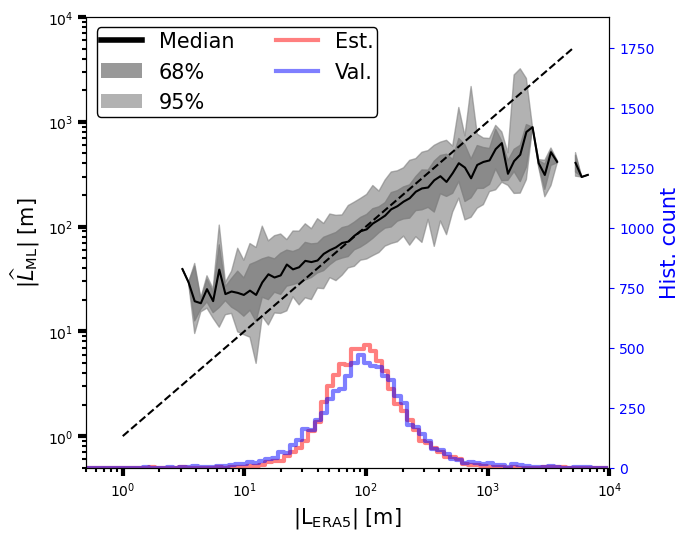

In [22]:
#%% Plot results

df_plot = pd.DataFrame()
df_plot['y_test'] = 10**result.y_test
df_plot['y_ML'] = 10**result.y_pred

hist_steps = 100
title = 'Correction using stacked regression from ERA5 $L$'
x_axis_title = r"|L$_{\mathrm{ERA5}}$| [$\mathrm{m}$]"
y_axis_title = r"|$\widehat{L}_{\mathrm{ML}}$| [$\mathrm{m}$]"
param_test = 'y_test'
param_predict = 'y_ML'

bin_centre, bin_median, bin_count_test, bin_count_pred, bin_std, fig2 = eqm.plot_envelope_single(df_plot = df_plot, hist_steps = hist_steps, param_test = param_test, param_predict = param_predict, 
                                                 title = title, x_axis_title = x_axis_title, y_axis_title = y_axis_title, alpha = 0.5, legend = True)

In [21]:
#%% load previous study
stacking_regressor = joblib.load(f"{data_dir}/examp_rolls_regression/" + "stacked_model.joblib")
pred = stacking_regressor.predict(result.X_test)

r2 = r2_score(result.y_test, pred)
mae = median_absolute_error(result.y_test, pred)
print(f"Model explains {np.round(r2,3)*100}% of variance with a Median Absolute Error of {np.round(mae,3)} (on a log scale)")

Model explains 67.4% of variance with a Median Absolute Error of 0.115 (on a log scale)


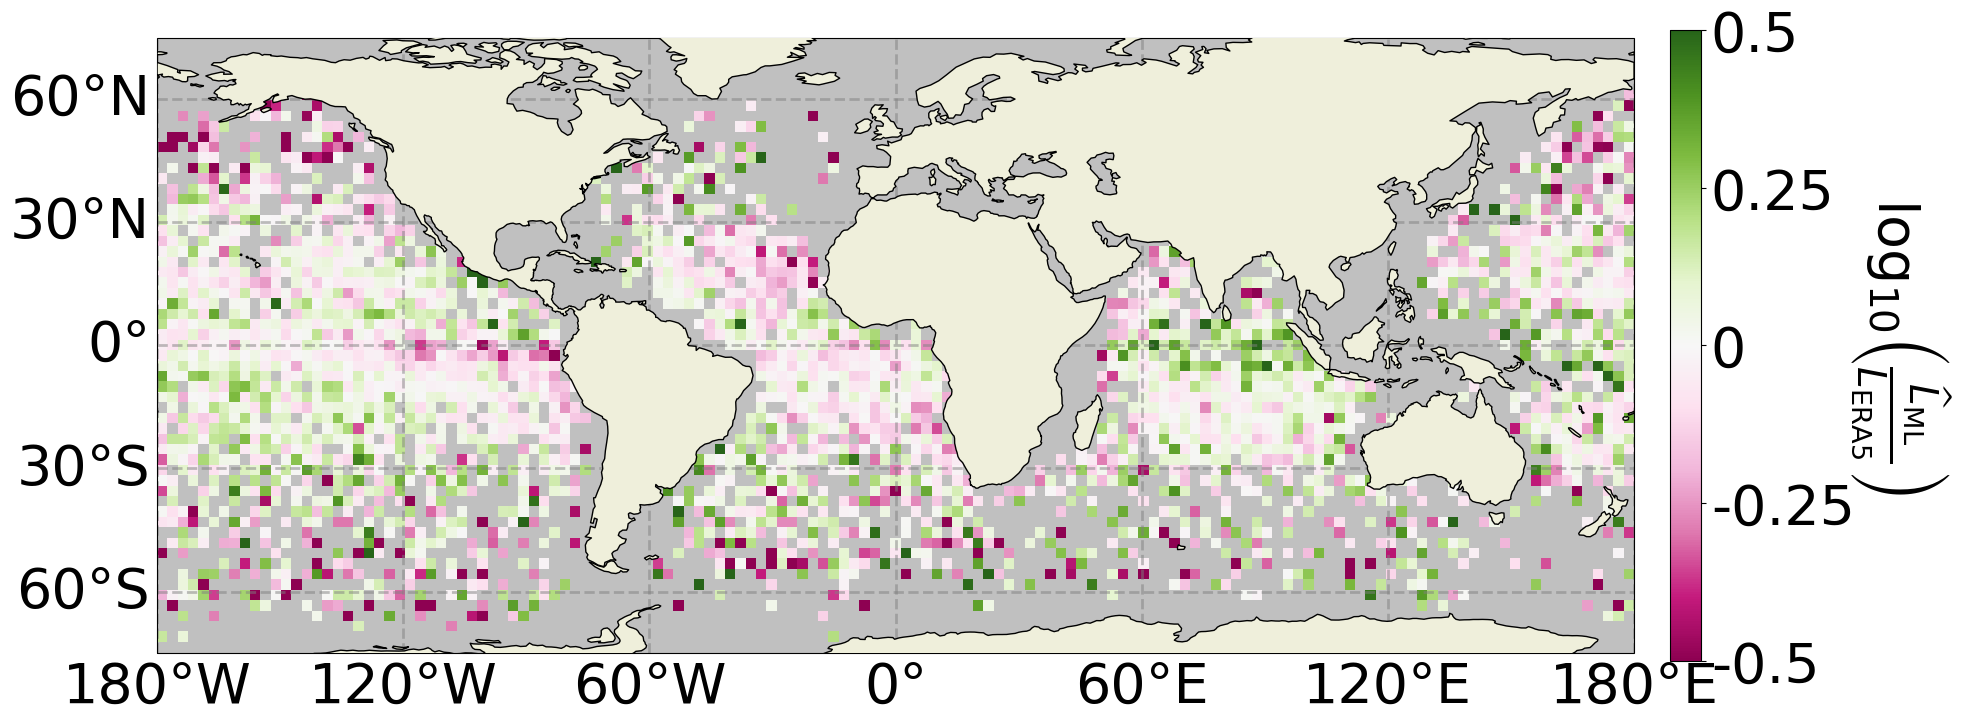

In [19]:
#%% plot global performance

df_input = df_plot
df_input['lat'] = df_val['lat_sar'][result.test_index]
df_input['lon'] = df_val['lon_sar'][result.test_index]
df_input['rem_error_ML'] = np.log10(df_plot['y_ML']) - np.log10(df_plot['y_test'])
variables = ['rem_error_ML']
statistics = ['median']
norms = [matplotlib.colors.Normalize(vmin=-0.50, vmax=0.5)]
cmaps = ['PiYG'] # PiYG  PuRd inferno
rows = 1
columns = 1
shrink = 0.65
resolution = 2.5
pad = 0.02
labelpad = 70 # 30
title = ''
fontsize = 40 # 20
labelsize = 40 # 20
xticks = [-180, -120, -60, 0, 60, 120, 180]
figsize = (20, 10)
cbar_ticks = [-0.5, -0.25, 0, 0.25, 0.5]
cbar_labels = ['-0.5', '-0.25', '0', '0.25', '0.5']
cbar_title = r'$\mathrm{log_{10}}\left(\frac{\widehat{L}_{\mathrm{ML}}}{L_{\mathrm{ERA5}}}\right)$' 
fig, datas = eqm.world_maps_single(df_input = df_input, variables = variables, title = title, cbar_title = cbar_title, statistics = statistics, \
                              norms = norms, cmaps = cmaps, rows = rows, columns = columns, shrink = shrink, resolution = resolution, pad = pad, \
                              fontsize = fontsize, labelsize = labelsize, labelpad = labelpad, cbar_ticks=cbar_ticks, cbar_labels=cbar_labels,
                              figsize = figsize, 
                              #extent = extent, xticks = xticks, yticks = yticks
                              )
